In [2]:
import os
import cv2
import PIL
import torch
import torchvision.transforms as transforms
import torchvision.models.segmentation as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
torch.backends.cudnn.benchmark = True

True
cuda:0
NVIDIA GeForce RTX 3060 Ti


In [3]:
label_map = np.array([
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

In [4]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()
  
    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.
  
    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)
  
    for label_num in range(0, len(label_map)):
        index = labels == label_num
         
        R, G, B = label_map[label_num]
  
        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B
  
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

In [5]:
def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum
  
    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  
    return image

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights, 
                                             DeepLabV3_ResNet101_Weights, 
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

In [7]:
def load_model(model_name: str):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")
         
    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT).to(device)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
  
    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).to(device)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
     
    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT).to(device)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
  
    model.eval()
    
    # Warmup run - move the input tensor to the device
    _ = model(torch.randn(1, 3, 520, 520).to(device))
    
    return model, transforms

In [8]:
def perform_inference(model_name: str, num_images=10, image_dir=None, save_images=False, device=None):
     
    if save_images:
        seg_map_save_dir = os.path.join("results", model_name, "segmentation_map")
        overlayed_save_dir = os.path.join("results", model_name, "overlayed_images")
         
        os.makedirs(seg_map_save_dir, exist_ok=True)
        os.makedirs(overlayed_save_dir, exist_ok=True)
     
    device = device if device is not None else ("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model, transforms = load_model(model_name)
    model.to(device)
  
    # Load image handles for the validation set.
    with open(r"./content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt") as f:
        val_set_image_names = f.read().split("\n")
  
    # Randomly select 'num_images' from the whole set for inference.
    selected_images = np.random.choice(val_set_image_names, num_images, replace=False)
  
    # Iterate over selected images
    for img_handle in selected_images:
         
        # Load and pre-process image.
        image_name = img_handle + ".jpg"
        image_path = os.path.join(image_dir, image_name)
        img_raw = PIL.Image.open(image_path).convert("RGB")
        W, H = img_raw.size[:2]
        img_t = transforms(img_raw).to(device)
        img_t = torch.unsqueeze(img_t, dim=0).to(device)
  
        # Model Inference
        with torch.no_grad():
            output = model(img_t)["out"].cpu()
  
        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)
  
        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
        overlayed_image = image_overlay(img_raw, segmented_image)
         
        # Plot
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(np.asarray(img_raw))
  
        plt.subplot(1, 3, 2)
        plt.title("Segmentation")
        plt.axis("off")
        plt.imshow(segmented_image)
  
        plt.subplot(1, 3, 3)
        plt.title("Overlayed")
        plt.axis("off")
        plt.imshow(overlayed_image[:, :, ::-1])

        plt.show()
        plt.close()
  
        # Save Segmented and overlayed images
        if save_images:
            cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
            cv2.imwrite(overlayed_save_dir, overlayed_image)
  
    return

cuda:0
cuda:0


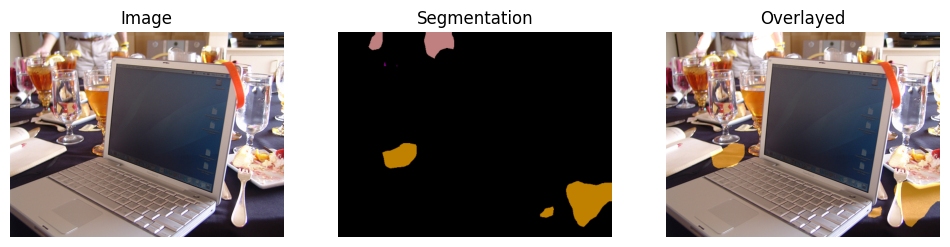

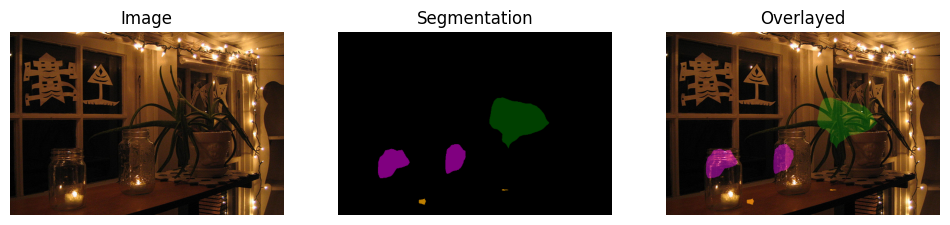

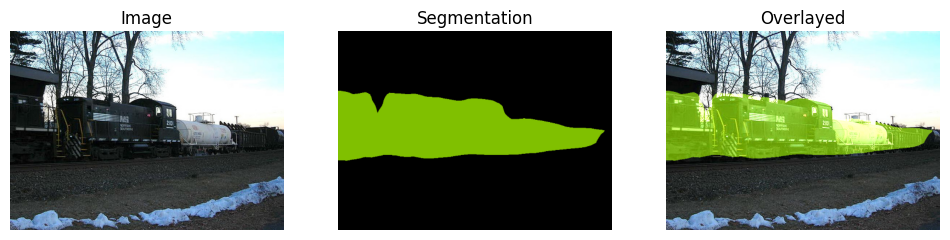

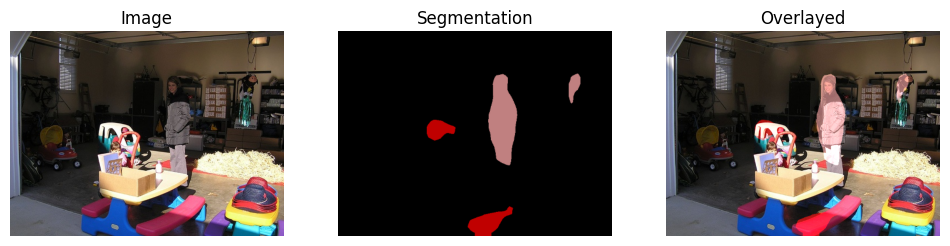

In [9]:
ROOT_raw_image_directory = r"./content/VOCdevkit/VOC2012/JPEGImages"
  
model_name = 'mobilenet' # "mobilenet", "resnet_50", resnet_101
num_images = 4
save = False
  
perform_inference(
    model_name=model_name, 
    num_images=num_images, 
    save_images=save, 
    image_dir=ROOT_raw_image_directory
)

In [10]:
def prepare_model(backbone_model="mbv3", num_classes=25):
    weights = 'DEFAULT'    # Initialize model with pre-trained weights.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    if backbone_model == "mbv3":
        model = deeplabv3_mobilenet_v3_large(weights=weights)
    elif backbone_model == "r50":
        model = deeplabv3_resnet50(weights=weights)
    elif backbone_model == "r101":
        model = deeplabv3_resnet101(weights=weights)
    else:
        raise ValueError("Wrong backbone model passed. Must be one of 'mbv3', 'r50' and 'r101' ")
 
    # Update the number of output channels for the output layer.
    # This will remove the pre-trained weights for the last layer.
    model.classifier[4]         = nn.LazyConv2d(num_classes, 1)
    model.aux_classifier[4] = nn.LazyConv2d(num_classes, 1)
    model = model.to(device)
    
    return model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = prepare_model(num_classes=25)
print(device)
model.to(device)

cuda:0
cuda:0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    criterion = criterion.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            print(f"loss: {loss.item()}")

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")


In [13]:
# Define the color map
color_map = {
    0: [0, 0, 0],                # void
    1: [108, 64, 20],            # dirt
    2: [255, 229, 204],          # sand
    3: [0, 102, 0],              # grass
    4: [0, 255, 0],              # tree
    5: [0, 153, 153],            # pole
    6: [0, 128, 255],            # water
    7: [0, 0, 255],              # sky
    8: [255, 255, 0],            # vehicle
    9: [255, 0, 127],            # container/generic-object
    10: [64, 64, 64],            # asphalt
    11: [255, 128, 0],           # gravel
    12: [255, 0, 0],             # building
    13: [153, 76, 0],            # mulch
    14: [102, 102, 0],           # rock-bed
    15: [102, 0, 0],             # log
    16: [0, 255, 128],           # bicycle
    17: [204, 153, 255],         # person
    18: [102, 0, 204],           # fence
    19: [255, 153, 204],         # bush
    20: [0, 102, 102],           # sign
    21: [153, 204, 255],         # rock
    22: [102, 255, 255],         # bridge
    23: [101, 101, 11],          # concrete
    24: [114, 85, 47]            # picnic-table
}

# Create a reverse lookup to map colors to class labels
color_to_class = {tuple(value): key for key, value in color_map.items()}

def color_to_class_label(mask):
    # Create an empty label mask
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)  # Use np.int32 instead of np.long
    
    # For each pixel, get the RGB value and map it to the class label
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            rgb_value = tuple(mask[i, j])
            if rgb_value in color_to_class:
                label_mask[i, j] = color_to_class[rgb_value]
            else:
                label_mask[i, j] = 0  # Default to class 0 if color is not found

    return label_mask

# Reading and processing the mask
mask_path = './content/RUGD_annotations/trail-5/trail-5_00041.png'
mask = cv2.imread(mask_path)  # Read the mask image (RGB format)
mask = cv2.resize(mask, (688, 550), interpolation=cv2.INTER_NEAREST)  # Resize the mask

# Convert the mask to class labels
label_mask = color_to_class_label(mask)

# Convert to a torch tensor for further use in PyTorch
label_mask_tensor = torch.tensor(label_mask, dtype=torch.long).to(device)

# Optional: Print unique values in the mask to check if the conversion worked
print("Unique values in the label mask:", torch.unique(label_mask_tensor))

# Now, label_mask_tensor can be used for training or other purposes


Unique values in the label mask: tensor([ 0,  3,  4,  6, 12], device='cuda:0')


In [14]:
from torch.utils.data import Dataset, DataLoader

import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class RUGDDataset(Dataset):
    def __init__(self, image_folder, mask_folder, img_size=(688, 550), transform=None, device=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.img_size = img_size
        self.transform = transform
        self.device = device if device is not None else (torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        
        # Color map (RGB -> class index)
        self.color_map = {
            0: [0, 0, 0],                # void
            1: [108, 64, 20],            # dirt
            2: [255, 229, 204],          # sand
            3: [0, 102, 0],              # grass
            4: [0, 255, 0],              # tree
            5: [0, 153, 153],            # pole
            6: [0, 128, 255],            # water
            7: [0, 0, 255],              # sky
            8: [255, 255, 0],            # vehicle
            9: [255, 0, 127],            # container/generic-object
            10: [64, 64, 64],            # asphalt
            11: [255, 128, 0],           # gravel
            12: [255, 0, 0],             # building
            13: [153, 76, 0],            # mulch
            14: [102, 102, 0],           # rock-bed
            15: [102, 0, 0],             # log
            16: [0, 255, 128],           # bicycle
            17: [204, 153, 255],         # person
            18: [102, 0, 204],           # fence
            19: [255, 153, 204],         # bush
            20: [0, 102, 102],           # sign
            21: [153, 204, 255],         # rock
            22: [102, 255, 255],         # bridge
            23: [101, 101, 11],          # concrete
            24: [114, 85, 47]            # picnic-table
        }

        # Get all image and mask filenames from all subdirectories
        self.image_filenames = []
        for root, dirs, files in os.walk(image_folder):
            for file in files:
                if file.endswith('.png'):
                    self.image_filenames.append(os.path.relpath(os.path.join(root, file), image_folder))

        self.mask_filenames = []
        for root, dirs, files in os.walk(mask_folder):
            for file in files:
                if file.endswith('.png'):
                    self.mask_filenames.append(os.path.relpath(os.path.join(root, file), mask_folder))

        # Ensure there's a corresponding mask for each image
        assert len(self.image_filenames) == len(self.mask_filenames), \
            f"Mismatch between number of images and masks: {len(self.image_filenames)} vs {len(self.mask_filenames)}"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Construct the path for the image and corresponding mask
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_filenames[idx]) 
        
        # Read image and mask
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).to(device)

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Convert the mask to class labels
        label_mask = color_to_class_label(mask)
        
        # Convert to a torch tensor for further use in PyTorch
        mask = torch.tensor(label_mask, dtype=torch.long).to(self.device)
        
        # Optional: Print unique values in the mask to check if the conversion worked
        print("Unique values in the label mask:", torch.unique(mask))

        return img, mask


# Define dataset paths
IMAGE_FOLDER = "./content/RUGD_frames"
MASK_FOLDER = "./content/RUGD_annotations"

# Create Dataloaders
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_dataset = RUGDDataset(IMAGE_FOLDER, MASK_FOLDER, device=device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

cuda:0


In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

cuda:0
Unique values in the label mask: tensor([ 3,  4,  6, 12, 17], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4,  7, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4, 12, 14, 17, 20], device='cuda:0')
Unique values in the label mask: tensor([ 0,  4, 12], device='cuda:0')
Unique values in the label mask: tensor([ 3,  4,  6, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4,  6, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4, 11, 12], device='cuda:0')
Unique values in the label mask: tensor([ 3,  4,  6, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4,  6, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4, 10, 12], device='cuda:0')
Unique values in the label mask: tensor([ 0,  3,  4,  6,  7, 12, 14], device='cuda:0')
Unique values in the label mask: tensor([ 3,  4, 